In [2]:
print("ankul")

ankul


In [3]:
! pip install -r requirements.txt


     |████████████████████████████████| 797.1 MB 12 kB/s  eta 0:00:0160:37     |▏                               | 3.0 MB 206 kB/s eta 1:04:03     |▏                               | 4.1 MB 29 kB/s eta 7:30:04     |▏                               | 4.6 MB 265 kB/s eta 0:49:50     |▋                               | 14.8 MB 3.5 MB/s eta 0:03:45     |▉                               | 21.3 MB 1.8 MB/s eta 0:07:18     |█                               | 23.3 MB 2.3 MB/s eta 0:05:31     |█                               | 25.4 MB 2.4 MB/s eta 0:05:27     |█                               | 25.5 MB 2.4 MB/s eta 0:05:27     |█▏                              | 30.4 MB 2.0 MB/s eta 0:06:17     |█▌                              | 37.5 MB 4.1 MB/s eta 0:03:07     |█▌                              | 37.8 MB 4.1 MB/s eta 0:03:07     |█▊                              | 44.1 MB 1.0 MB/s eta 0:12:24     |█▊                              | 44.2 MB 1.0 MB/s eta 0:12:24     |█▉                              | 44.3 M

[0/700] LossD: 1.6218 LossG: 0.7194


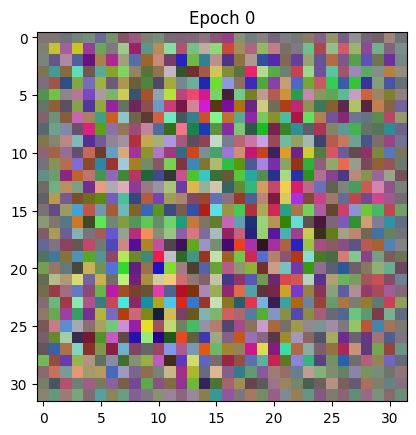

[50/700] LossD: 0.3164 LossG: 2.1079


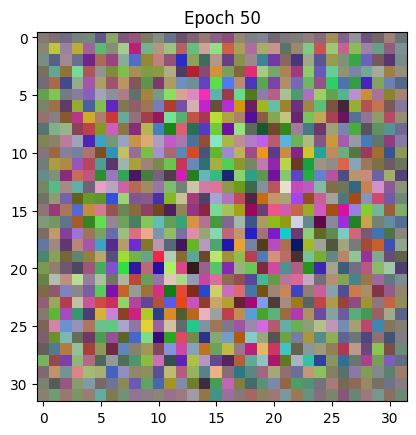

[100/700] LossD: 0.1495 LossG: 2.8349


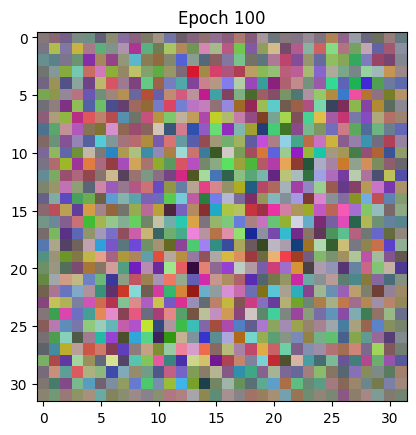

[150/700] LossD: 0.0789 LossG: 3.5005


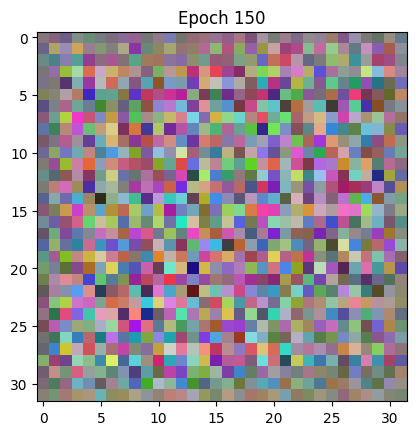

[200/700] LossD: 0.0521 LossG: 4.0024


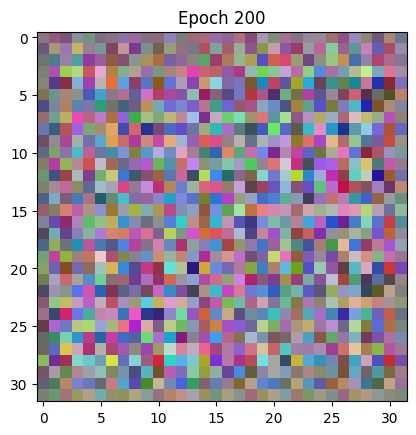

[250/700] LossD: 0.0416 LossG: 4.0553


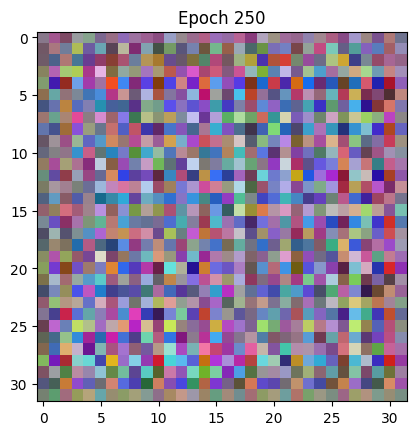

[300/700] LossD: 0.0234 LossG: 5.2015


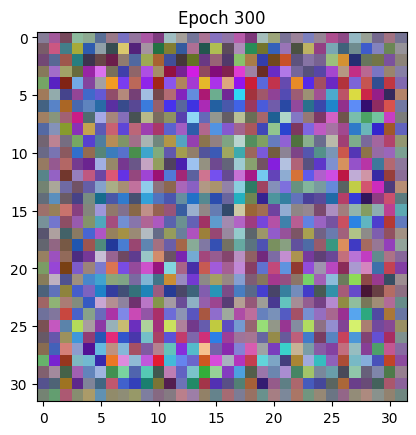

[350/700] LossD: 0.0321 LossG: 4.2675


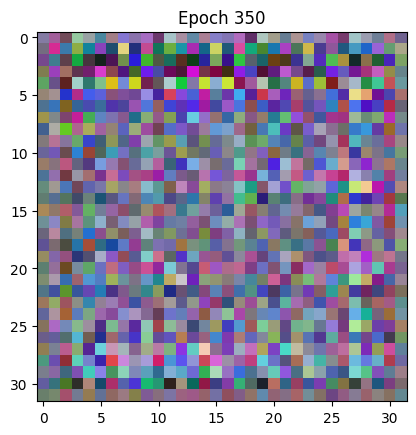

[400/700] LossD: 0.0385 LossG: 4.0555


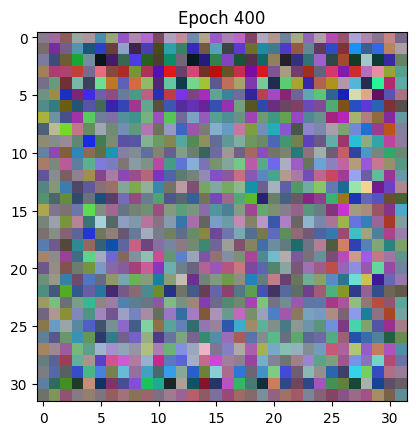

[450/700] LossD: 0.0276 LossG: 4.5022


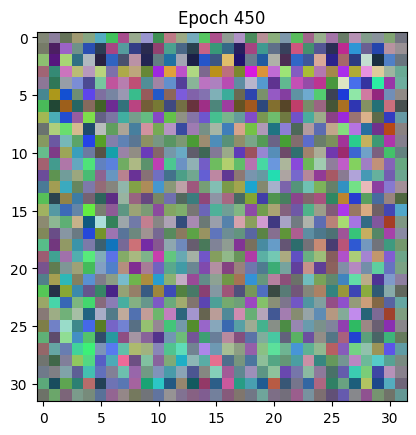

[500/700] LossD: 0.0200 LossG: 4.8077


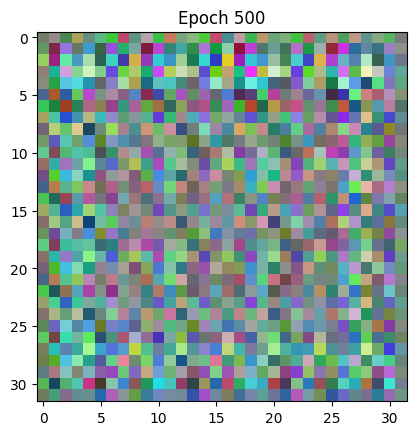

[550/700] LossD: 0.0117 LossG: 5.5474


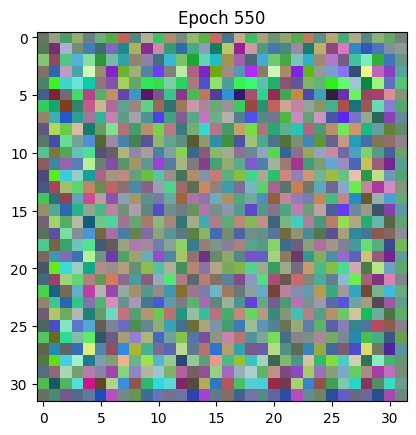

[600/700] LossD: 0.0150 LossG: 4.9883


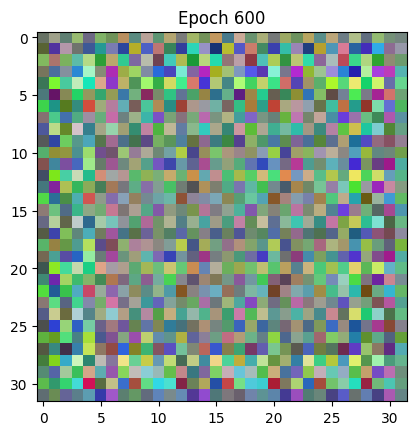

[650/700] LossD: 0.0092 LossG: 5.6736


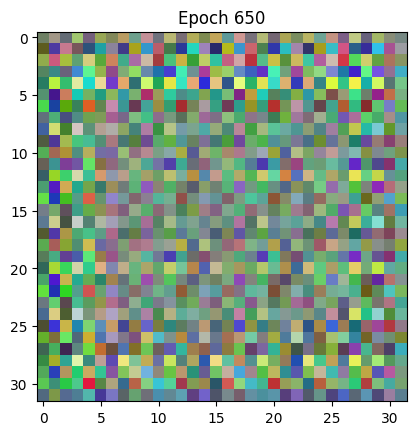

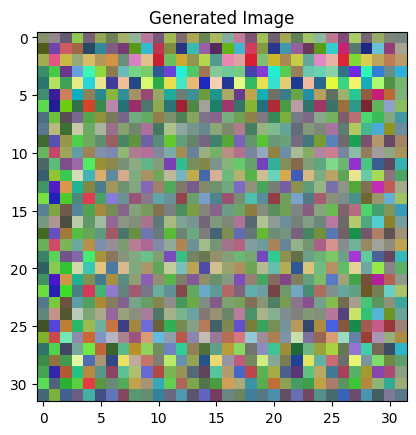

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# ------------------------
# 1. Load Single Image
# ------------------------
image_path = "/home/hp/Desktop/learn/Screenshot from 2025-09-18 11-58-11.png"   # 👈 replace with your image
img = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # resize to 64x64
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalize to [-1, 1]
])

real_img = transform(img).unsqueeze(0)  # shape: [1, 3, 64, 64]

# ------------------------
# 2. Define Generator & Discriminator
# ------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# ------------------------
# 3. Initialize Models
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(1, 100, 1, 1, device=device)

# ------------------------
# 4. Training Loop
# ------------------------
epochs = 700
real_img = real_img.to(device)

for epoch in range(epochs):
    # Train Discriminator
    netD.zero_grad()

    output_real = netD(real_img).view(-1)
    label_real = torch.ones_like(output_real, device=device)  # ✅ match size
    lossD_real = criterion(output_real, label_real)
    lossD_real.backward()

    noise = torch.randn(1, 100, 1, 1, device=device)
    fake_img = netG(noise)
    output_fake = netD(fake_img.detach()).view(-1)
    label_fake = torch.zeros_like(output_fake, device=device)  # ✅ match size
    lossD_fake = criterion(output_fake, label_fake)
    lossD_fake.backward()
    optimizerD.step()

    # Train Generator
    netG.zero_grad()
    output = netD(fake_img).view(-1)
    label_gen = torch.ones_like(output, device=device)  # ✅ fool D
    lossG = criterion(output, label_gen)
    lossG.backward()
    optimizerG.step()

    if epoch % 50 == 0:
        print(f"[{epoch}/{epochs}] LossD: {lossD_real+lossD_fake:.4f} LossG: {lossG:.4f}")
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        plt.imshow(np.transpose(fake[0]*0.5+0.5, (1, 2, 0)))
        plt.title(f"Epoch {epoch}")
        plt.show()

# ------------------------
# 5. Save Final Output
# ------------------------
with torch.no_grad():
    final_fake = netG(fixed_noise).detach().cpu()
plt.imshow(np.transpose(final_fake[0]*0.5+0.5, (1, 2, 0)))
plt.title("Generated Image")
plt.show()


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Get all image file paths from the directory
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply the transform if provided
        if self.transform:
            image = self.transform(image)
        
        return image

In [2]:
transform = transforms.Compose([
    transforms.Resize(64),  # Resize images to 64x64
    transforms.CenterCrop(64),  # Crop center to 64x64
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Update dataset path
dataset_path = '/home/hp/Desktop/learn/img_align_celeba (1)/img_align_celeba'

# Load CelebA dataset
dataset = CelebADataset(root_dir=dataset_path, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Check how many images are loaded
# all_files = os.listdir(dataset_path)
# print("Number of files:", len(all_files))
# print("First 10 files:", all_files[:10])
print(f"Total number of images loaded: {len(dataset)}")

Total number of images loaded: 202599


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

# ------------------------
# 1. Custom CelebA Dataset
# ------------------------
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f)
                            for f in os.listdir(root_dir)
                            if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


# ------------------------
# 2. Generator & Discriminator
# ------------------------
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_channels * 64 * 64),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 64, 64)  # reshape to image
        return img


class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_channels * 64 * 64, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


# ------------------------
# 3. Setup
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

z_dim = 100
generator = Generator(z_dim=z_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# ------------------------
# 4. DataLoader
# ------------------------
dataset_path = "/home/hp/Desktop/learn/img_align_celeba (1)/img_align_celeba"

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # scale to [-1, 1]
])

dataset = CelebADataset(root_dir=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

print(f"Total images loaded: {len(dataset)}")


# ------------------------
# 5. Training Utilities
# ------------------------
def save_generated_images(generator, epoch, device, num_images=16):
    z = torch.randn(num_images, z_dim).to(device)
    generated_imgs = generator(z).detach().cpu()
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.show()


# ------------------------
# 6. Training Loop
# ------------------------
def train(generator, discriminator, dataloader, epochs=10):
    for epoch in range(epochs):
        for i, imgs in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)

            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            z = torch.randn(batch_size, z_dim).to(device)
            fake_imgs = generator(z)
            fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, z_dim).to(device))), valid)
            g_loss.backward()
            optimizer_G.step()

            if i % 50 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                      f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        # Show generated samples after each epoch
        save_generated_images(generator, epoch, device)


# ------------------------
# 7. Run Training
# ------------------------
train(generator, discriminator, dataloader, epochs=1)


Using device: cpu
Total images loaded: 202599
[Epoch 0/1] [Batch 0/1583] [D loss: 0.6923] [G loss: 0.6807]
[Epoch 0/1] [Batch 50/1583] [D loss: 0.3210] [G loss: 1.0066]
[Epoch 0/1] [Batch 100/1583] [D loss: 0.1710] [G loss: 1.4723]
[Epoch 0/1] [Batch 150/1583] [D loss: 0.0991] [G loss: 2.0209]
[Epoch 0/1] [Batch 200/1583] [D loss: 0.3643] [G loss: 0.9669]
[Epoch 0/1] [Batch 250/1583] [D loss: 0.4859] [G loss: 0.4933]
[Epoch 0/1] [Batch 300/1583] [D loss: 0.1505] [G loss: 1.6290]
[Epoch 0/1] [Batch 350/1583] [D loss: 0.4511] [G loss: 1.9517]
[Epoch 0/1] [Batch 400/1583] [D loss: 0.3971] [G loss: 0.8568]
[Epoch 0/1] [Batch 450/1583] [D loss: 0.2845] [G loss: 1.6518]
[Epoch 0/1] [Batch 500/1583] [D loss: 0.1259] [G loss: 2.8112]
[Epoch 0/1] [Batch 550/1583] [D loss: 0.0822] [G loss: 2.6153]
[Epoch 0/1] [Batch 600/1583] [D loss: 0.0947] [G loss: 2.5023]
[Epoch 0/1] [Batch 650/1583] [D loss: 0.1917] [G loss: 1.0284]
[Epoch 0/1] [Batch 700/1583] [D loss: 0.4179] [G loss: 2.4371]
[Epoch 0/1] 